In [10]:
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range

import tensorflow

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

!pip3 install tensorboard
import tensorboard

In [11]:
# Download the data. The data is already divided into train and test.
# The labels are integers representing classes.
fashion_mnist = tensorflow.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = \
    fashion_mnist.load_data()

# Names of the integer classes, i.e., 0 -> T-short/top, 1 -> Trouser, etc.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Visualisierung eines einzelnen Bildes

Um zu verstehen, wie die API für die Bildzusammenfassung funktioniert, protokollieren Sie jetzt einfach das erste Trainingsbild in Ihrem Trainingssatz in TensorBoard.

Bevor Sie dies tun, überprüfen Sie die Form Ihrer Trainingsdaten:

In [12]:
print("Shape: ", train_images[0].shape)
print("Label: ", train_labels[0], "->", class_names[train_labels[0]])

Shape:  (28, 28)
Label:  9 -> Ankle boot


Beachten Sie, dass die Form jedes Bildes im Datensatz ein Formtensor vom Rang 2 (28, 28) ist, der die Höhe und die Breite darstellt.

tf.summary.image() erwartet jedoch einen Tensor vom Rang 4, der enthält (batch_size, height, width, channels) . Daher müssen die Tensoren umgeformt werden.

Sie protokollieren nur ein Bild, also ist batch_size 1. Die Bilder sind Graustufen, setzen Sie also die channels auf 1.

In [13]:
# Reshape the image for the Summary API.
img = np.reshape(train_images[0], (-1, 28, 28, 1))

Sie können dieses Bild jetzt protokollieren und in TensorBoard anzeigen.

In [14]:
# Clear out any prior log data.
!rm -rf logs

# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

Verwenden Sie jetzt TensorBoard, um das Bild zu untersuchen. Warten Sie einige Sekunden, bis sich die Benutzeroberfläche dreht.

In [16]:
%load_ext tensorboard
%tensorboard --logdir logs/train_data

Auf der Registerkarte "Bilder" wird das gerade protokollierte Bild angezeigt. Es ist ein "Ankle Boot".

Das Bild wird zur einfacheren Anzeige auf eine Standardgröße skaliert. Wenn Sie das nicht skalierte Originalbild anzeigen möchten, aktivieren Sie oben links "Aktuelle Bildgröße anzeigen".

Spielen Sie mit den Schiebereglern für Helligkeit und Kontrast, um zu sehen, wie sie sich auf die Bildpixel auswirken.

Visualisierung mehrerer Bilder

Das Protokollieren eines Tensors ist großartig, aber was ist, wenn Sie mehrere Trainingsbeispiele protokollieren möchten?

Geben Sie einfach die Anzahl der Bilder an, die Sie protokollieren möchten, wenn Sie Daten an tf.summary.image() übergeben.

In [18]:
with file_writer.as_default():
  # Don't forget to reshape.
  images = np.reshape(train_images[0:25], (-1, 28, 28, 1))
  tf.summary.image("25 training data examples", images, max_outputs=25, step=0)

%tensorboard --logdir logs/train_data

Reusing TensorBoard on port 6006 (pid 23766), started 0:03:01 ago. (Use '!kill 23766' to kill it.)

Was ist, wenn Sie ein Bild visualisieren möchten, das kein Tensor ist, z. B. ein von matplotlib erzeugtes Bild ?

Sie benötigen einen Boilerplate-Code, um den Plot in einen Tensor umzuwandeln, aber danach können Sie loslegen.

Im folgenden Code protokollieren Sie die ersten 25 Bilder mit der Funktion subplot subplot() von matplotlib als schönes Raster. Anschließend wird das Raster in TensorBoard angezeigt:

In [34]:
# Clear out prior logging data.
!rm -rf logs/plots

logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def image_grid():
    """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
    # Create a figure to contain the plot.
    figure = plt.figure(figsize=(10,10))
    for i in range(25):
        # Start next subplot.
        plt.subplot(5, 5, i + 1, title=class_names[train_labels[i]])
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    return figure

# Prepare the plot
figure = image_grid()
# Convert to image and log
with file_writer.as_default():
    tf.summary.image("Training data", plot_to_image(figure), step=0)

%tensorboard --logdir logs/plots

Stellen Sie dies nun mit einem echten Beispiel zusammen. Schließlich sind Sie hier, um maschinelles Lernen zu betreiben und keine schönen Bilder zu zeichnen!

Sie werden Bildzusammenfassungen verwenden, um zu verstehen, wie gut Ihr Modell funktioniert, während Sie einen einfachen Klassifikator für den Fashion-MNIST-Datensatz trainieren.

Erstellen Sie zunächst ein sehr einfaches Modell und kompilieren Sie es, indem Sie den Optimierer und die Verlustfunktion einrichten. Der Kompilierungsschritt gibt außerdem an, dass Sie die Genauigkeit des Klassifizierers auf dem Weg protokollieren möchten.

In [21]:
from tensorflow.keras import models,layers

model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Wenn Sie einen Klassifikator trainieren, ist es nützlich, die Verwirrungsmatrix zu sehen. Die Verwirrungsmatrix gibt Ihnen detaillierte Informationen darüber, wie Ihr Klassifikator mit Testdaten arbeitet.

Definieren Sie eine Funktion, die die Verwirrungsmatrix berechnet. Dazu verwenden Sie eine praktische Scikit-Lernfunktion und zeichnen sie dann mit matplotlib.

In [22]:
def plot_confusion_matrix(cm, class_names):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

Sie können jetzt den Klassifikator trainieren und die Verwirrungsmatrix auf dem Weg regelmäßig protokollieren.

Folgendes werden Sie tun:

Erstellen Sie den Keras TensorBoard-Rückruf , um grundlegende Metriken zu protokollieren
Erstellen Sie einen Keras LambdaCallback , um die Verwirrungsmatrix am Ende jeder Epoche zu protokollieren
Trainieren Sie das Modell mit Model.fit () und stellen Sie sicher, dass beide Rückrufe bestanden werden
Scrollen Sie im Verlauf des Trainings nach unten, um zu sehen, wie TensorBoard gestartet wird.

In [28]:
# Clear out prior logging data.
!rm -rf logs/image

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [32]:
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(test_images)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = tensorflow.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

Reusing TensorBoard on port 6007 (pid 23791), started 0:02:40 ago. (Use '!kill 23791' to kill it.)

W1015 07:55:18.857119 4407344576 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0009s vs `on_train_batch_end` time: 0.0046s). Check your callbacks.


NameError: name 'plot_to_image' is not defined

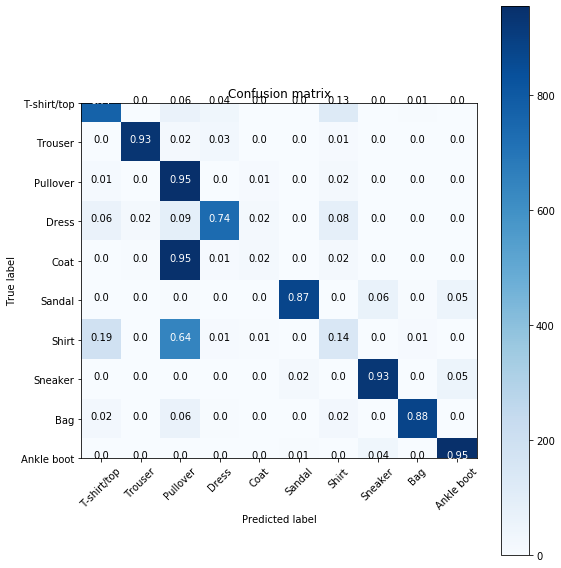

In [33]:
# Start TensorBoard.
%tensorboard --logdir logs/image

# Train the classifier.
model.fit(
    train_images,
    train_labels,
    epochs=5,
    verbose=0, # Suppress chatty output
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_images, test_labels),
)
